In [33]:
import pyodbc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xml.etree.ElementTree as ET
import pandas as pd
import os
import re
import random

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from scipy import stats
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
 
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score
from statsmodels.api import OLS, add_constant
from scipy.stats import ttest_ind, chi2
from statsmodels.formula.api import mixedlm, ols
from statsmodels.stats.anova import anova_lm

In [2]:
df = pd.read_csv('df_total.csv')

In [3]:
df = df[['Part_nbr', 'Lot_nbr', 'Layer', 'd_Layer','AVGX','AVGY','MacNo', 'MacRecipe', 'mtl_desc2', 'vend_nbr',
         'layer_2Thick', 'plate_mtl_desc1', 'plate_mtl_desc2','plate_vend_nbr', 'plate_layer_2Thick', 'plate_RC_value',
         'Residual Copper Rate', 'glass_fabric_thickness(mm)',
         'use_cu_upper_thickness', 'use_cu_lower_thickness', 'use_cu_type',
         'glass_fabric_type', 'short', 'long', 'd_PSVarX', 'd_PSVarY']]

df = df.copy()
df['layer_2Thick'] = df['layer_2Thick'].replace('None', np.nan).astype(float)
df['layer_2Thick'] = df['layer_2Thick'].astype('float')

df['plate_mtl_desc2'] = df['plate_mtl_desc2'].astype('float')

df['plate_layer_2Thick'] = pd.to_numeric(df['plate_layer_2Thick'], errors='coerce')
df = df.rename(columns={"glass_fabric_thickness(mm)": "glass_fabric_thickness_mm"})
df = df.rename(columns={"Residual Copper Rate": "Residual_Copper_Rate"})

In [4]:
df.isna().sum()

Part_nbr                         0
Lot_nbr                          0
Layer                            0
d_Layer                          0
AVGX                             0
AVGY                             0
MacNo                            0
MacRecipe                      182
mtl_desc2                        0
vend_nbr                         0
layer_2Thick                  4990
plate_mtl_desc1                  0
plate_mtl_desc2                  0
plate_vend_nbr                   0
plate_layer_2Thick           24755
plate_RC_value               52124
Residual_Copper_Rate             0
glass_fabric_thickness_mm      786
use_cu_upper_thickness         786
use_cu_lower_thickness         786
use_cu_type                   1417
glass_fabric_type             1811
short                         3653
long                          3653
d_PSVarX                         0
d_PSVarY                         0
dtype: int64

In [5]:
df['plate_RC_value'].unique()

array([nan, 65., 63., 56., 73., 77., 64., 54., 57., 67., 62., 69., 52.,
       58., 74., 72., 70., 60., 75., 76., 71., 66., 78., 53., 61., 59.,
       68., 45., 55., 79.])

In [6]:
part_counts = df['Part_nbr'].value_counts()

part_counts.describe()

count    1320.000000
mean       42.361364
std       145.618470
min         1.000000
25%        12.000000
50%        20.000000
75%        36.000000
max      3000.000000
Name: count, dtype: float64

In [7]:
# 找出小於閾值的料號列表
part_counts = df['Part_nbr'].value_counts()

threshold = 20
below_threshold_parts = part_counts[part_counts < threshold].index.tolist()

print(f"小於 {threshold} 筆數據的料號共有 {len(below_threshold_parts)} 個：")
# print(below_threshold_parts)

小於 20 筆數據的料號共有 647 個：


In [8]:
# 計算各料號的觀測數
part_counts = df['Part_nbr'].value_counts()

threshold = 20
df['Part_nbr_grouped'] = np.where(df['Part_nbr'].map(part_counts) < threshold,   'OTHER', df['Part_nbr'])

# 按分位數合併（合併底部25%）
# quantile_threshold = part_counts.quantile(0.25)
# df['Part_nbr_grouped'] = np.where(df['Part_nbr'].map(part_counts) < quantile_threshold, 'OTHER', df['Part_nbr'])

<p style = "font_size: 16; color: blue;">Modeling 前處理</p>

In [9]:
# 以每個 lot的RC補NaN
l2_rc_map = (
    df[df['d_Layer'] == 'L2']
    .dropna(subset=['plate_RC_value'])
    .groupby('Lot_nbr')['plate_RC_value']
    .first()
)

first_rc_map = (
    df.dropna(subset=['plate_RC_value'])
    .groupby('Lot_nbr')['plate_RC_value']
    .first()
)

final_rc_map = l2_rc_map.combine_first(first_rc_map)

df['plate_RC_value'] = df['plate_RC_value'].fillna(df['Lot_nbr'].map(final_rc_map))

In [10]:
# 剩下的用整體中位數補
overall_median_rc = df['plate_RC_value'].median()

rc_missing_parts = df[df['plate_RC_value'].isna()].groupby('Part_nbr')['plate_RC_value'].count()

all_parts_count = df.groupby('Part_nbr')['plate_RC_value'].count()

rc_missing_parts_aligned = rc_missing_parts.reindex(all_parts_count.index, fill_value=0)

fully_missing_parts = all_parts_count[rc_missing_parts_aligned == all_parts_count].index

df.loc[df['Part_nbr'].isin(fully_missing_parts), 'plate_RC_value'] = overall_median_rc

<p style="font-size: 14px; color: blue;"> 找出遺失值數量(比例)</p>

In [11]:
features_with_na = [features for features in df.columns if df[features].isnull().sum() > 1]

for feature in features_with_na:
    print(feature, df[feature].isnull().sum(), 'missing values')

MacRecipe 182 missing values
layer_2Thick 4990 missing values
plate_layer_2Thick 24755 missing values
glass_fabric_thickness_mm 786 missing values
use_cu_upper_thickness 786 missing values
use_cu_lower_thickness 786 missing values
use_cu_type 1417 missing values
glass_fabric_type 1811 missing values
short 3653 missing values
long 3653 missing values


<p style="font-size: 14px; color: blue;">找出有遺失值的數值型特徵<p>

In [12]:
numerical_features = [feature for feature in df.columns if df[feature].dtypes!='O']

print('Number of features: ',len(numerical_features))

# df[numerical_features].head()

Number of features:  16


<p style="font-size: 14px; color: blue;">找出有遺失值的離散型特徵<p>

In [13]:
discrete_feature = [feature for feature in numerical_features if len(df[feature].unique())<25]
print('Discrete variables count: {}'.format(len(discrete_feature)))
discrete_feature 

Discrete variables count: 3


['MacNo', 'use_cu_upper_thickness', 'use_cu_lower_thickness']

<p style="font-size: 14px; color: blue;">找出有遺失值的類別型特徵<p>

In [14]:
categorical_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print(len(categorical_features))
print(categorical_features)

11
['Part_nbr', 'Lot_nbr', 'Layer', 'd_Layer', 'MacRecipe', 'vend_nbr', 'plate_mtl_desc1', 'plate_vend_nbr', 'use_cu_type', 'glass_fabric_type', 'Part_nbr_grouped']


In [15]:
for feature in categorical_features:
    print('The feature is {} and number of categories are {}'.format(feature, len(df[feature].unique())))

The feature is Part_nbr and number of categories are 1320
The feature is Lot_nbr and number of categories are 4255
The feature is Layer and number of categories are 18
The feature is d_Layer and number of categories are 40
The feature is MacRecipe and number of categories are 205
The feature is vend_nbr and number of categories are 11
The feature is plate_mtl_desc1 and number of categories are 107
The feature is plate_vend_nbr and number of categories are 9
The feature is use_cu_type and number of categories are 44
The feature is glass_fabric_type and number of categories are 86
The feature is Part_nbr_grouped and number of categories are 674


<p style="font-size: 14px; color: blue;">處理離散型遺失值<p>

In [16]:
features_nan = [feature for feature in df.columns if df[feature].isnull().sum()>1 and df[feature].dtype=='O']

for feature in features_nan:
    print('{}: {} missing value'.format(feature, df[feature].isnull().sum()))

MacRecipe: 182 missing value
use_cu_type: 1417 missing value
glass_fabric_type: 1811 missing value


In [17]:
#這裡是將有nan的data挑出來，把nan換成Missing 標籤，因為等等要編碼(encode)，它不能是nan
def replace_cat_feature(data, features_nan):
    data1 = data.copy()
    data1[features_nan]=data[features_nan].fillna('Missing')
    return data1

df = replace_cat_feature(df, features_nan)

#nan沒有了，變成了Missing 標籤，所以都是0
df[features_nan].isnull().sum()

MacRecipe            0
use_cu_type          0
glass_fabric_type    0
dtype: int64

<p style="font-size: 14px; color: blue;">處理數值型遺失值<p>

In [18]:
numerical_with_nan = [feature for feature in df.columns if df[feature].isnull().sum()>1 and df[feature].dtype!='O']

for feature in numerical_with_nan:
    print('{}: {} missing value'.format(feature, df[feature].isnull().sum()))

layer_2Thick: 4990 missing value
plate_layer_2Thick: 24755 missing value
glass_fabric_thickness_mm: 786 missing value
use_cu_upper_thickness: 786 missing value
use_cu_lower_thickness: 786 missing value
short: 3653 missing value
long: 3653 missing value


In [19]:
# 先對每個數值欄位進行分群中位數填補
for feature in numerical_with_nan:
    # 新增一欄標示缺失
    df[feature + '_nan'] = np.where(df[feature].isnull(), 1, 0)
    
    # 對每個 (Part_nbr, Lot_nbr) 群組算中位數來填補
    df[feature] = df.groupby(['Part_nbr', 'Lot_nbr'])[feature]\
                        .transform(lambda x: x.fillna(x.median()))

# 若還有 NaN，用整體中位數補
for feature in numerical_with_nan:
    df[feature] = df[feature].fillna(df[feature].median())


C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\wilson_liu\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\lib\_nanfunctions_impl.py:1215: RuntimeWarning: Mean of empty slice
  return np.

In [20]:
df[numerical_with_nan].isnull().sum()

layer_2Thick                 0
plate_layer_2Thick           0
glass_fabric_thickness_mm    0
use_cu_upper_thickness       0
use_cu_lower_thickness       0
short                        0
long                         0
dtype: int64

<p style="font-size: 14px; color: blue;">處理類別型遺失值<p>

In [21]:
categorical_feattures = [feature for feature in df.columns if df[feature].dtypes=='O' ]
categorical_feattures

['Part_nbr',
 'Lot_nbr',
 'Layer',
 'd_Layer',
 'MacRecipe',
 'vend_nbr',
 'plate_mtl_desc1',
 'plate_vend_nbr',
 'use_cu_type',
 'glass_fabric_type',
 'Part_nbr_grouped']

In [22]:
# 你想保留的欄位（不處理的）
excluded_features = ['Part_nbr', 'Lot_nbr', 'Layer', 'd_Layer', 'Part_nbr_grouped']

# 建立一個新的列表，過濾掉 excluded_features
processed_categorical_features = [f for f in categorical_features if f not in excluded_features]

# rare category 合併
for feature in processed_categorical_features:
    temp = df.groupby(feature)['d_PSVarX'].count() / len(df)
    temp_df = temp[temp > 0.01].index
    df[feature] = np.where(df[feature].isin(temp_df), df[feature], 'rare cate')

# target mean encoding
for feature in processed_categorical_features:
    labels_ordered = df.groupby([feature])['d_PSVarX'].mean().sort_values().index
    labels_ordered = {k: i for i, k in enumerate(labels_ordered, 0)}
    df[feature] = df[feature].map(labels_ordered)


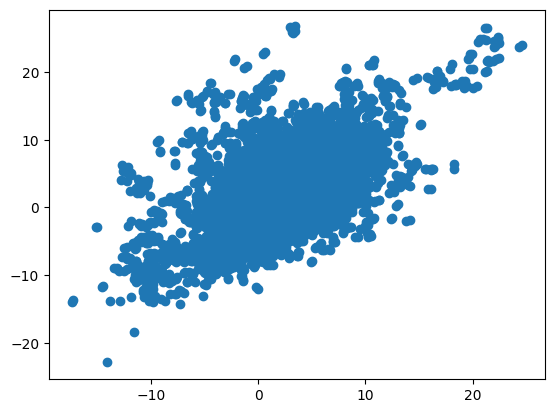

In [23]:
df = df[df['d_PSVarX'] < 4000]
plt.scatter(df['d_PSVarX'],df['d_PSVarY'])

In [24]:
df.columns

Index(['Part_nbr', 'Lot_nbr', 'Layer', 'd_Layer', 'AVGX', 'AVGY', 'MacNo',
       'MacRecipe', 'mtl_desc2', 'vend_nbr', 'layer_2Thick', 'plate_mtl_desc1',
       'plate_mtl_desc2', 'plate_vend_nbr', 'plate_layer_2Thick',
       'plate_RC_value', 'Residual_Copper_Rate', 'glass_fabric_thickness_mm',
       'use_cu_upper_thickness', 'use_cu_lower_thickness', 'use_cu_type',
       'glass_fabric_type', 'short', 'long', 'd_PSVarX', 'd_PSVarY',
       'Part_nbr_grouped', 'layer_2Thick_nan', 'plate_layer_2Thick_nan',
       'glass_fabric_thickness_mm_nan', 'use_cu_upper_thickness_nan',
       'use_cu_lower_thickness_nan', 'short_nan', 'long_nan'],
      dtype='object')

In [25]:
# from sklearn.preprocessing import PowerTransformer
# pt = PowerTransformer(method='yeo-johnson')
# df['d_PSVarX_trans'] = pt.fit_transform(df[['d_PSVarX']])

In [54]:
formula = """
d_PSVarY ~ mtl_desc2 + layer_2Thick + plate_mtl_desc2 + plate_layer_2Thick + plate_RC_value +
           Residual_Copper_Rate + glass_fabric_thickness_mm + use_cu_upper_thickness + long + use_cu_lower_thickness +
           C(use_cu_type) + C(glass_fabric_type) + C(vend_nbr) + C(MacRecipe) + C(MacNo)
           """
model = mixedlm(formula, data=df, groups="Part_nbr_grouped") # , re_formula="~Lot_nbr"
result = model.fit()

In [55]:
result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                Mixed Linear Model Regression Results
=====================================================================
Model:                 MixedLM    Dependent Variable:    d_PSVarY    
No. Observations:      55897      Method:                REML        
No. Groups:            674        Scale:                 4.9974      
Min. group size:       20         Log-Likelihood:        -125603.5833
Max. group size:       6693       Converged:             Yes         
Mean group size:       82.9                                          
---------------------------------------------------------------------
                           Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   5.754    1.364  4.217 0.000  3.080  8.428
C(use_cu_type)[T.1]        -0.269    0.193 -1.395 0.163 -0.648  0.109
C(use_cu_type)[T.2]        -0.238    0.146 -1.632 0.103 -0.523  0.048
C(use_cu_type)[T.3]         0.822    0.235  3.504 0.000  0.362  1.282
C(use_cu_type)[T.4]        -0.004    0.151 -0.027 0.978 -0.300  0.291
C(use_cu_type)[T.5]         0.162    0.153  1.062 0.288 -0.137  0.462
C(use_cu_type)[T.6]         0.157    0.155  1.013 0.311 -0.147  0.462
C(use_cu_type)[T.7]         0.451    0.157  2.878 0.004  0.144  0.758
C(use_cu_type)[T.8]         0.166    0.155  1.067 0.286 -0.139  0.470
C(use_cu_type)[T.9]        -0.119    0.196 -0.610 0.542 -0.504  0.265
C(use_cu_type)[T.10]       -0.104    0.152 -0.682 0.496 -0.402  0.195
C(use_cu_type)[T.11]        0.007    0.151  0.049 0.961 -0.289  0.304
C(glass_fabric_type)[T.1]  -1.873    0.249 -7.507 0.000 -2.362 -1.384
C(glass_fabric_type)[T.2]  -0.255    0.231 -1.105 0.269 -0.707  0.197
C(glass_fabric_type)[T.3]  -0.916    0.208 -4.412 0.000 -1.324 -0.509
C(glass_fabric_type)[T.4]  -0.831    0.255 -3.256 0.001 -1.331 -0.331
C(glass_fabric_type)[T.5]  -0.677    0.204 -3.322 0.001 -1.076 -0.278
C(glass_fabric_type)[T.6]  -0.376    0.232 -1.619 0.105 -0.830  0.079
C(glass_fabric_type)[T.7]  -0.563    0.202 -2.780 0.005 -0.960 -0.166
C(glass_fabric_type)[T.8]  -0.151    0.204 -0.737 0.461 -0.551  0.250
C(glass_fabric_type)[T.9]  -0.611    0.244 -2.502 0.012 -1.089 -0.132
C(glass_fabric_type)[T.10] -1.179    0.268 -4.390 0.000 -1.705 -0.653
C(glass_fabric_type)[T.11] -0.430    0.207 -2.072 0.038 -0.837 -0.023
C(glass_fabric_type)[T.12] -0.105    0.229 -0.458 0.647 -0.553  0.343
C(glass_fabric_type)[T.13] -0.665    0.197 -3.371 0.001 -1.052 -0.278
C(glass_fabric_type)[T.14] -0.749    0.201 -3.719 0.000 -1.144 -0.354
C(vend_nbr)[T.1]            2.346    0.262  8.941 0.000  1.831  2.860
C(vend_nbr)[T.2]            2.550    0.194 13.117 0.000  2.169  2.931
C(vend_nbr)[T.3]            1.416    0.204  6.935 0.000  1.015  1.816
C(vend_nbr)[T.4]            1.313    0.182  7.227 0.000  0.957  1.669
C(vend_nbr)[T.5]            3.757    0.287 13.089 0.000  3.195  4.320
C(vend_nbr)[T.6]            1.519    0.179  8.496 0.000  1.169  1.870
C(MacRecipe)[T.1]          -1.237    0.478 -2.587 0.010 -2.174 -0.300
C(MacRecipe)[T.2]          -0.720    0.351 -2.050 0.040 -1.408 -0.032
C(MacRecipe)[T.3]          -0.135    0.328 -0.411 0.681 -0.777  0.508
C(MacRecipe)[T.4]          -0.176    0.339 -0.520 0.603 -0.840  0.488
C(MacRecipe)[T.5]          -0.599    0.397 -1.510 0.131 -1.376  0.179
C(MacRecipe)[T.6]          -0.876    0.350 -2.500 0.012 -1.563 -0.189
C(MacRecipe)[T.7]           0.069    0.344  0.200 0.841 -0.606  0.744
C(MacRecipe)[T.8]          -0.307    0.342 -0.899 0.369 -0.978  0.363
C(MacRecipe)[T.9]           0.225    0.483  0.467 0.641 -0.721  1.172
C(MacRecipe)[T.10]          0.374    0.348  1.075 0.282 -0.308  1.056
C(MacRecipe)[T.11]          0.091    0.364  0.248 0.804 -0.624  0.805
C(MacRecipe)[T.12]         -0.195    0.351 -0.557 0.578 -0.883  0.492
C(MacRecipe)[T.13]         -0.233    0.387 -0.601 0.548 -0.992  0.526
C(MacRecipe)[T.14]         -2.275    0.534 -4.2

In [63]:
# LRT

formula1 = """
d_PSVarY ~ mtl_desc2 + layer_2Thick + plate_mtl_desc2 + plate_layer_2Thick + plate_RC_value +
           Residual_Copper_Rate + glass_fabric_thickness_mm + use_cu_upper_thickness + long + use_cu_lower_thickness +
           C(use_cu_type) + C(glass_fabric_type) + C(vend_nbr) + C(MacRecipe) + C(MacNo)
           """
full = mixedlm(formula1, df, groups=df['Part_nbr']).fit()

formula2 = """
d_PSVarY ~ mtl_desc2 + layer_2Thick + plate_mtl_desc2 + plate_layer_2Thick + plate_RC_value +
           Residual_Copper_Rate + glass_fabric_thickness_mm + use_cu_upper_thickness + long + use_cu_lower_thickness +
           C(use_cu_type) + C(glass_fabric_type) + C(vend_nbr) + C(MacRecipe) + C(MacNo)
           """
reduced = mixedlm(formula2, df, groups=df['Part_nbr']).fit()

df_diff = (len(full.params) - len(reduced.params))

lr_stat = 2 * (full.llf - reduced.llf) 
p_value = chi2.sf(lr_stat, df=df_diff) 

print(f"Likelihood Ratio Test Results:")
print(f"LR Statistic: {lr_stat:.4f}")
print(f"Degrees of Freedom: {df_diff}")
print(f"p-value: {p_value:.4g}")

Likelihood Ratio Test Results:
LR Statistic: 244.8873
Degrees of Freedom: 21
p-value: 4.357e-40


In [47]:
from statsmodels.regression.mixed_linear_model import MixedLM

n_bootstrap = 30  
bootstrap_results = []

# 按料號分組重抽樣 (保留料號內部的數據結構)
unique_parts = df['Part_nbr_grouped'].unique()

for i in range(n_bootstrap):
    # 重抽樣料號 (with replacement)
    sampled_parts = np.random.choice(unique_parts, size=len(unique_parts), replace=True)
    
    # 根據抽中的料號構建新數據集
    bootstrap_sample = pd.concat(
        [df[df['Part_nbr_grouped'] == part] for part in sampled_parts]
    )
    
    # 擬合模型
    model = MixedLM.from_formula(
        formula, 
        data=bootstrap_sample, 
        groups=bootstrap_sample['Part_nbr_grouped']
    )
    result = model.fit(reml=False)  # 使用 ML 而非 REML 以利比較
    
    # 儲存參數估計
    bootstrap_results.append(result.params)



In [49]:
# 將結果轉為 DataFrame
bootstrap_df = pd.DataFrame(bootstrap_results)

# 計算參數的 Bootstrap 估計 (中位數) 和 95% 置信區間
param_summary = pd.DataFrame({
    'mean': bootstrap_df.mean(),
    'median': bootstrap_df.median(),
    '2.5%': bootstrap_df.quantile(0.025),
    '97.5%': bootstrap_df.quantile(0.975),
    'std_error': bootstrap_df.std()
})

print("Bootstrap 參數估計摘要:")
display(param_summary)

Bootstrap 參數估計摘要:


,mean,median,2.5%,97.5%,std_error
Intercept,-388.185144,2.817225,-1485.066701,5.078919,565.709701
C(use_cu_type)[T.1],-0.480163,-0.320461,-2.536653,1.057023,0.925431
C(use_cu_type)[T.2],-0.608098,-0.501350,-2.120715,0.791218,0.790542
C(use_cu_type)[T.3],0.432192,0.496819,-1.247258,1.955495,0.875731
C(use_cu_type)[T.4],-0.498575,-0.394803,-2.007696,0.986239,0.819773
C(use_cu_type)[T.5],-0.270517,-0.165138,-1.817837,1.273600,0.869638
C(use_cu_type)[T.6],-0.412699,-0.364789,-2.002001,1.190155,0.883458
C(use_cu_type)[T.7],-0.096319,-0.001925,-1.893541,1.329933,0.883162
C(use_cu_type)[T.8],-0.153474,-0.068326,-1.683838,1.287387,0.864746
C(use_cu_type)[T.9],-0.356773,-0.362769,-1.967509,1.041432,0.869020


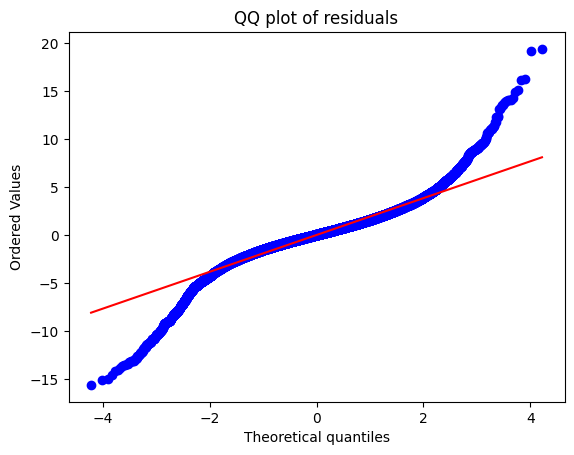

In [28]:
residuals = result.resid

# Q-Q Plot
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ plot of residuals")
plt.show()


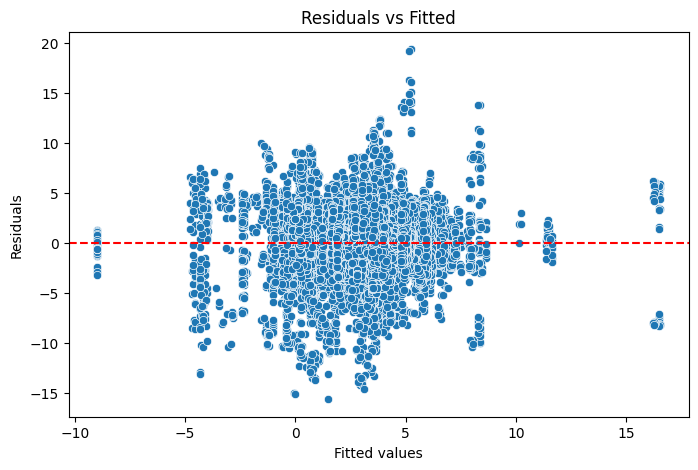

In [29]:
fitted = result.fittedvalues
resid = result.resid

plt.figure(figsize=(8,5))
sns.scatterplot(x=fitted, y=resid)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()